In [2]:
import tqdm

import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
import scipy.interpolate as interpolate

from fiesta.train.DataManager import DataManager
from fiesta.train.AfterglowData import RunPyblastafterglow

file = "./model/pyblastafterglow_raw_data.h5"

### Remove the nans

In [20]:
with h5py.File(file) as f:
    times = f["times"][:]
    nus = f["nus"][:]
    log_flux = f["test"]["y"][2].reshape(256, 344)

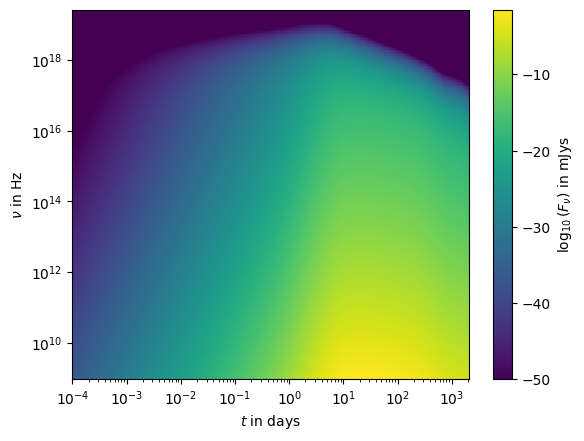

In [21]:
plt.pcolormesh((times), (nus), log_flux)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$t$ in days")
plt.ylabel("$\\nu$ in Hz")
plt.colorbar(label="$\\log_{10}(F_{\\nu})$ in mJys")

In [31]:
def remove_nans(log_flux):

    log_flux = log_flux.reshape(*nus.shape, *times.shape)
    log_flux = log_flux[:,94:]

    interp = interpolate.interp1d(np.log10(times[94:]),
                                  log_flux, 
                                  axis=1, 
                                  fill_value="extrapolate")

    return interp(np.log10(times))

In [39]:
with h5py.File("./model/pyblastafterglow_raw_data.h5", "r+") as f:
    for group in ["train", "val", "test"]:
        problematic_indices = np.where(np.isnan(f[group]["y"][:,0]))[0]
        print(group, problematic_indices)
        
        for ind in tqdm.tqdm(problematic_indices):
            fixed_data = remove_nans(f[group]["y"][ind])
            f[group]["y"][ind] = fixed_data.flatten()

train [ 4459  6160  7845  9723 12098 15676 15881 22624 29666 30988 31578 35018
 35391 38430 39785 41435 45466 47671 51310 56350 56751 56757 57808 59466
 64203 65120 65424 66251 66256 66722 67602 68705 68827 72630 74808 76909
 80297 81052 82537 83376 85373 85675 87634 89759 90820]


  0%|          | 0/45 [00:00<?, ?it/s]/home/enlil/hkoehn/miniconda3/envs/fiesta/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 45/45 [00:00<00:00, 906.56it/s]


val [4038 5603]


100%|██████████| 2/2 [00:00<00:00, 730.14it/s]


test [1473 2528]


100%|██████████| 2/2 [00:00<00:00, 761.01it/s]


### Remove the infs

In [44]:
with h5py.File("./model/pyblastafterglow_raw_data.h5", "r+") as f:
    for group in ["val", "test"]:
        f[group]["y"][:] = np.maximum(f[group]["y"][:], -50)

In [6]:
with h5py.File("./model/pyblastafterglow_raw_data.h5", "r+") as f:
    f["train"]["y"][:20_000] = np.maximum(f["train"]["y"][:20_000], -50)
    f["train"]["y"][20_000:40_000] = np.maximum(f["train"]["y"][20_000:40_000], -50)
    f["train"]["y"][40_000:60_000] = np.maximum(f["train"]["y"][40_000:60_000], -50)
    f["train"]["y"][60_000:80_000] = np.maximum(f["train"]["y"][60_000:80_000], -50)
    f["train"]["y"][80_000:] = np.maximum(f["train"]["y"][80_000:], -50)